In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
%matplotlib inline

## Question 3 - Decision Trees

In [2]:
df_train = pd.read_csv("data/faces_train_data.csv")
df_test = pd.read_csv("data/faces_test_data.csv")

In [3]:
print(df_train.head())
print(df_train.describe())

      x0     y0     x1     y1     x2     y2     x3     y3     x4     y4  ...  \
0 -1.861  1.350 -1.835  0.892 -1.756  0.458 -1.704 -0.000 -1.625 -0.458  ...   
1 -1.920  1.523 -1.920  1.066 -1.833  0.571 -1.746  0.076 -1.571 -0.343  ...   
2 -1.247  1.177 -1.256  0.806 -1.183  0.403 -0.983  0.008 -0.746 -0.371  ...   
3 -1.660  1.812 -1.701  1.324 -1.660  0.801 -1.620  0.314 -1.498 -0.139  ...   
4 -1.776  1.551 -1.693  1.140 -1.549  0.729 -1.363  0.318 -1.115 -0.075  ...   

     y63    x64    y64    x65    y65    x66    y66    x67    y67  smiling  
0 -0.160  0.498 -0.343  0.183 -0.389 -0.026 -0.389 -0.210 -0.389        0  
1 -0.076  0.742 -0.076  0.262 -0.267  0.000 -0.305 -0.262 -0.267        1  
2 -0.055  1.247  0.016  0.464 -0.506  0.173 -0.553 -0.082 -0.537        1  
3 -0.070  0.891 -0.035  0.283 -0.279  0.000 -0.279 -0.283 -0.244        0  
4 -0.093  0.764  0.056  0.227 -0.112  0.041 -0.150 -0.145 -0.131        0  

[5 rows x 137 columns]
                x0           y0        

In [4]:
print(df_test.head())
print(df_test.describe())

      x0     y0     x1     y1     x2     y2     x3     y3     x4     y4  ...  \
0 -3.109  1.440 -3.067  0.847 -2.982  0.212 -2.811 -0.381 -2.385 -0.847  ...   
1 -2.747  1.159 -2.693  0.669 -2.585  0.223 -2.424 -0.268 -2.208 -0.669  ...   
2 -2.370  1.604 -2.326  1.130 -2.238  0.656 -2.107  0.182 -1.843 -0.255  ...   
3 -2.696  2.059 -2.684  1.503 -2.620  0.935 -2.505  0.378 -2.262 -0.116  ...   
4 -2.072  2.017 -1.950  1.504 -1.788  1.027 -1.625  0.550 -1.381  0.110  ...   

     y63    x64    y64    x65    y65    x66    y66    x67    y67  smiling  
0 -0.085  0.383 -0.000  0.170 -0.127  0.000 -0.212 -0.213 -0.212        1  
1 -0.089  0.485 -0.134  0.269 -0.357  0.054 -0.446 -0.215 -0.446        0  
2 -0.109  0.571 -0.146  0.176 -0.146  0.000 -0.146 -0.219 -0.146        0  
3 -0.053  0.422 -0.042  0.153 -0.137 -0.038 -0.179 -0.256 -0.168        0  
4 -0.037  0.731  0.073  0.244 -0.037  0.000 -0.073 -0.203 -0.073        0  

[5 rows x 137 columns]
                x0           y0        

The train dataset has 4800 observations, and the test dataset has 1200 observations. This a traditional 75%-25% split of the whole datset to train the model. Each observation is composed of 68 (x, y) pairs of points.

In [5]:
smiling_mean_points = df_train[df_train["smiling"] == 1].drop(labels=["smiling"], axis=1).mean(axis=0).values
smiling_mean_points_x = smiling_mean_points[0::2]
smiling_mean_points_y = smiling_mean_points[1::2]

In [6]:
non_smiling_mean_points = df_train[df_train["smiling"] == 0].drop(labels=["smiling"], axis=1).mean(axis=0).values
non_smiling_mean_points_x = non_smiling_mean_points[0::2]
non_smiling_mean_points_y = non_smiling_mean_points[1::2]

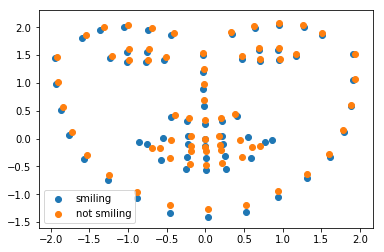

In [21]:
plt.scatter(smiling_mean_points_x, smiling_mean_points_y, label="smiling")
plt.scatter(non_smiling_mean_points_x, non_smiling_mean_points_y, label="not smiling")
plt.legend()
plt.savefig("results/smile-no-smile-mean-scatter.png")
plt.show()

The major difference in the scatter plot is that for the smilling scatter plot we see that the face formed has its mouth open and lips raised. This alsp leads its chin to be slighly lower and eyes a bit more inclined compared to the not smiling plot.

In [8]:
tree = DecisionTreeClassifier(max_depth=20, random_state=2001)

In [9]:
X = df_train.drop(labels=["smiling"], axis=1)
y = df_train["smiling"]

In [10]:
X_test = df_test.drop(labels=["smiling"], axis=1)
y_test = df_test["smiling"]

We use `Gini Index` as default measure of purity in sklearn's `DecisionTreeClassifier`. Compared to entropy using `Gini` is computationally less expensive and is easier to calculate.

The `max_depth` parameter sets how deep the tree can grow and hence how complicated our model will be. Increasing the value of `max_depth` means we have a higher training accuracy, however we have to be careful not to overfit on the training data. If the `max_depth` is really high we observe our testing accuracy goes down. We need to find a sweet spot in between to have the best possible model. For small values we may not have enough distinguishing features to make an accurate model. For large values, the model becomes complicated and we will overfit on training data.

In [11]:
results = []
for depth in [2, 8, 20]:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=2001)
    tree.fit(X, y)
    train_acc = tree.score(X, y)
    test_acc = tree.score(X_test, y_test)
    results.append([depth, train_acc, test_acc])

In [29]:
for depth, train_acc, test_acc in results:
    print(f"{depth} & {round(train_acc*100, 3)}\% & {round(test_acc*100, 3)}\% \\ \\")

2 & 79.479\% & 78.167\% \ \
8 & 93.354\% & 84.083\% \ \
20 & 100.0\% & 81.5\% \ \


In [13]:
export_graphviz(
            tree,
            out_file =  "d8_smile.dot",
            feature_names = list(X.columns),
            class_names = ["smiling", "not smiling"],
            filled = True,
            rounded = True)

The model with `max_depth=8` is the best out of the three. We have the highest test accuracy, and much lower complexity than the model with 20 layers.

In [14]:
tree = DecisionTreeClassifier(max_depth=8, random_state=2001)
tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2001,
            splitter='best')

In [15]:
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(tree.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)

In [30]:
importances.head(3)

,feature,importance
100,x50,0.330
97,y48,0.090
59,y29,0.088


The three most important features are `x50, y48 and y29`. 

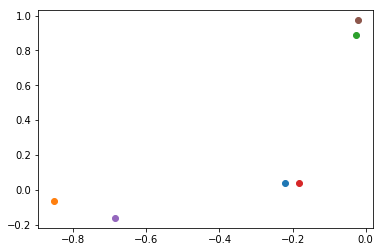

In [37]:
plt.plot(smiling_mean_points_x[50], smiling_mean_points_y[50], "o")
plt.plot(smiling_mean_points_x[48], smiling_mean_points_y[48], "o")
plt.plot(smiling_mean_points_x[29], smiling_mean_points_y[29], "o")
plt.plot(non_smiling_mean_points_x[50], non_smiling_mean_points_y[50], "o")
plt.plot(non_smiling_mean_points_x[48], non_smiling_mean_points_y[48], "o")
plt.plot(non_smiling_mean_points_x[29], non_smiling_mean_points_y[29], "o")

input (2d points) limitations?